## To Do list
- 0. 데이터 parquet 형식으로 변환 및 로드
- 1. 데이터 전처리(train,test dataset에서 모두 진행)
    - ID, Cancelled, Diverted 제거
    - Estimated_Departure_Time, Estimated_Arrival_Time 시와 분으로 나눠 볼 필요는 있을 듯
    - Origin_State, Destination_State를 Origin_Airport와 Destination_Airport를 기반으로 결측치 채워주기
    - 이후, Origin_Airport, Destination_Airport 제거
    - Distance 스케일링
    - Airline, Carrier_Code(IATA, DOT) 결측치 채우기
- 2. 예측에 도움되는 피쳐 고르기
- 3. 준지도학습 라벨링(train dataset에서 준지도학습 성능체크)
    - Delay있는 데이터 선택 후 검증세트 생성
    - 모델 탐색 및 피처 탐색 후 학습
    - 검증세트 생성 후 준지도학습 라벨링 성능지표 체크

### Import Module

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

### Read and Convert Data

In [3]:
def convert_parquet(df):
    csv_dir = f'./data/{df}.csv'
    read_df = pd.read_csv(csv_dir)
    read_df.to_parquet(path=f'./data/{df}.parquet')
    del read_df
    gc.collect()
    print(f'{df} Done')

In [4]:
#convert_parquet('train')
#convert_parquet('test')

train Done
test Done


### Data Preprocessing

ID, Cancelled, Diverted 제거

In [30]:
train = pd.read_parquet('./data/train.parquet')
test = pd.read_parquet('./data/test.parquet')

In [31]:
train = train.drop(['ID','Cancelled','Diverted'],axis=1)
test = test.drop(['ID','Cancelled','Diverted'],axis=1)

- Estimated_Departure_Time, Estimated_Arrival_Time 시와 분 분리

In [32]:
train.head()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,4,15,NaN,NaN,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None
1,8,15,740.0,1024.0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None
2,9,6,1610.0,1805.0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None
3,7,10,905.0,1735.0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,None
4,1,11,900.0,1019.0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,None


In [33]:
estimated_time = ['Estimated_Departure_Time', 'Estimated_Arrival_Time']

In [55]:
#estimated_time 컬럼 최다빈도 값으로 결측치 채우기
for i in estimated_time:
    most_freq = train[i].mode()[0]
    train[i] = train[i].fillna(most_freq)
    test[i] = test[i].fillna(most_freq)

In [54]:
train['Estimated_Departure_Time'].astype(int).astype(str).str.zfill(4).str.slice(0,2)

0         06
1         07
2         16
3         09
4         09
          ..
999995    09
999996    09
999997    08
999998    16
999999    18
Name: Estimated_Departure_Time, Length: 1000000, dtype: object

In [63]:
for df in [train,test]:
    df['Estimated_Departure_Hour'] = df['Estimated_Departure_Time'].astype(int).astype(str).str.zfill(4).str.slice(0,2).astype(int)
    df['Estimated_Departure_Min'] = df['Estimated_Departure_Time'].astype(int).astype(str).str.zfill(4).str.slice(2,4).astype(int)

    df['Estimated_Arrival_Hour'] = df['Estimated_Arrival_Time'].astype(int).astype(str).str.zfill(4).str.slice(0,2).astype(int)
    df['Estimated_Arrival_Min'] = df['Estimated_Arrival_Time'].astype(int).astype(str).str.zfill(4).str.slice(2,4).astype(int)

In [68]:
train = train.drop(['Estimated_Departure_Time','Estimated_Arrival_Time'],axis=1)
test = test.drop(['Estimated_Departure_Time','Estimated_Arrival_Time'],axis=1)

In [72]:
train.columns

Index(['Month', 'Day_of_Month', 'Origin_Airport', 'Origin_Airport_ID',
       'Origin_State', 'Destination_Airport', 'Destination_Airport_ID',
       'Destination_State', 'Distance', 'Airline', 'Carrier_Code(IATA)',
       'Carrier_ID(DOT)', 'Tail_Number', 'Delay', 'Estimated_Departure_Hour',
       'Estimated_Departure_Min', 'Estimated_Arrival_Hour',
       'Estimated_Arrival_Min'],
      dtype='object')

In [73]:
train.reindex(columns=['Month', 'Day_of_Month', 'Estimated_Departure_Hour',
                       'Estimated_Departure_Min', 'Estimated_Arrival_Hour',
                       'Estimated_Arrival_Min', 'Origin_Airport', 'Origin_Airport_ID',
                       'Origin_State', 'Destination_Airport', 'Destination_Airport_ID',
                       'Destination_State', 'Distance', 'Airline', 'Carrier_Code(IATA)',
                       'Carrier_ID(DOT)', 'Tail_Number', 'Delay'])
test.reindex(columns=['Month', 'Day_of_Month', 'Estimated_Departure_Hour',
                       'Estimated_Departure_Min', 'Estimated_Arrival_Hour',
                       'Estimated_Arrival_Min', 'Origin_Airport', 'Origin_Airport_ID',
                       'Origin_State', 'Destination_Airport', 'Destination_Airport_ID',
                       'Destination_State', 'Distance', 'Airline', 'Carrier_Code(IATA)',
                       'Carrier_ID(DOT)', 'Tail_Number', 'Delay'])


,Month,Day_of_Month,Estimated_Departure_Hour,Estimated_Departure_Min,Estimated_Arrival_Hour,Estimated_Arrival_Min,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,12,16,11,56,19,0,IAH,12266,Texas,SAT,14683,Texas,191.0,United Air Lines Inc.,UA,NaN,N79402,NaN
1,9,12,15,0,17,15,EWR,11618,New Jersey,ATL,10397,None,746.0,Delta Air Lines Inc.,DL,19790.0,N3765,NaN
2,3,6,16,0,19,15,ORD,13930,Illinois,LGA,12953,New York,733.0,United Air Lines Inc.,UA,19977.0,N413UA,NaN
3,5,18,19,20,20,45,OAK,13796,California,LAX,12892,California,337.0,Southwest Airlines Co.,WN,19393.0,N905WN,NaN
4,7,7,19,15,21,52,FLL,11697,Florida,LAX,12892,California,2343.0,JetBlue Airways,B6,20409.0,N945JT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,6,2,6,0,22,40,LAX,12892,California,DEN,11292,Colorado,862.0,Southwest Airlines Co.,WN,19393.0,N720WN,NaN
999996,6,8,6,0,6,48,BUF,10792,New York,ORD,13930,Illinois,473.0,United Air Lines Inc.,UA,19977.0,N401UA,NaN
999997,6,11,17,10,19,7,IAD,12264,None,DTW,11433,Michigan,383.0,Mesa Airlines Inc.,UA,20378.0,N510MJ,NaN
999998,11,17,6,0,5,0,SAN,14679,California,BOS,10721,Massachusetts,2588.0,JetBlue Airways,B6,20409.0,N986JB,NaN


<AxesSubplot:>

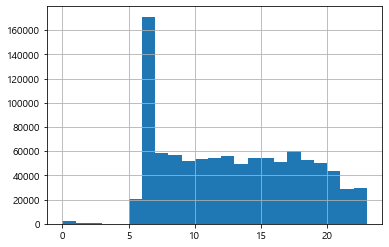

In [76]:
train['Estimated_Departure_Hour'].hist(bins=23)

<AxesSubplot:>

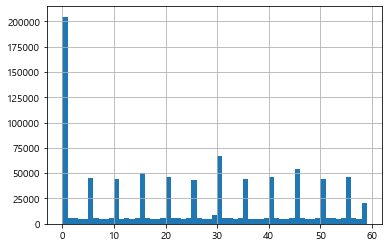

In [77]:
train['Estimated_Departure_Min'].hist(bins=59)

<AxesSubplot:>

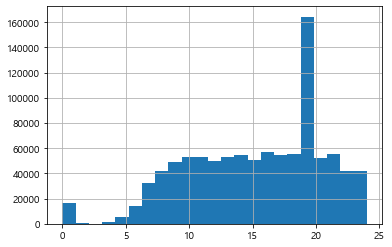

In [78]:
train['Estimated_Arrival_Hour'].hist(bins=23)

<AxesSubplot:>

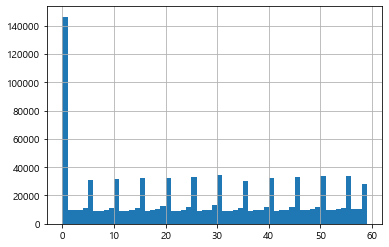

In [79]:
train['Estimated_Arrival_Min'].hist(bins=59)

- Origin_State, Destination_State를 Origin_Airport와 Destination_Airport를 기반으로 결측치 채워주기